## Yahoo Movies Reviews Analysis

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from googletrans import Translator

### Setting matplotlib font type

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

### Loading data

In [3]:
get_data = lambda x: x[0]
main_table = pd.read_csv('Movies data/main_table.csv', encoding = 'utf-8', index_col = 0).drop(columns = 'link')
main_table['names'] = main_table['names'].str.split('：|:').apply(func = get_data)
main_table.head(3)

,names,score,date
0,復仇者聯盟,4.6,2018-04-25
1,侏羅紀世界,4.3,2018-06-06
2,不可能的任務,4.5,2018-07-25


In [4]:
all_comment_df = pd.read_csv('Movies data/all_comments.csv', encoding = 'utf-8')
all_comment_df.sample(3)

,user_name,publish_time,comment,movies_key
4617,yuyu,2018-06-26 17:54:45,好看又搞笑，後面感人。長大後如果保有這樣的感情挺不錯的,29
167,大海愛藍天,2018-04-30 01:17:33,劇情緊湊精彩，從片頭到片尾雞皮疙瘩掉滿地了……有太多令人感動之處，只能說導演真的很強，不愧為...,0
2640,LBJkio,2018-07-30 11:30:43,真的好看~~好人壞人都強~~這樣才刺激啊!!!!!!!,12


In [5]:
map_dict = {ind: name for ind, name in zip(main_table.index, main_table['names'])}
all_comment_df['movies_key'] = all_comment_df['movies_key'].map(map_dict)
all_comment_df.sample(3)

,user_name,publish_time,comment,movies_key
818,宇智波鼬,2018-01-24 11:09:14,迷宮哩 迷宮到底在哪裡? 特效普通 就一堆炸藥亂炸 打鬥也普通 主角光環 前面的雜魚完全打不到主角,不可能的任務
2484,啾啾,2018-04-04 21:57:38,音效真的恐怖的沒話說這部在電影院的氣氛可以跟暫時停止呼吸做比較,瞞天過海
2395,飛飛,2018-04-12 22:01:31,評價很兩極的電影.................,瞞天過海


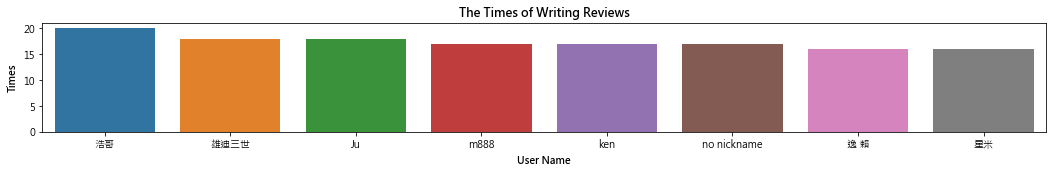

In [6]:
def rank_user(all_comment_df, min_num):
    rank_user_comment = all_comment_df.groupby(by = 'user_name').size().sort_values(ascending = False)
    if min_num > rank_user_comment[0]:
        raise ValueError('The min_num larger than {}'.format(rank_user_comment[0]))
    select_user_comment = rank_user_comment[rank_user_comment > min_num]

    title_font = {'color': 'black', 'size': 12, 'style': 'italic', 'weight': 'bold'}
    text_font = {'color': 'black', 'size': 10, 'style': 'italic', 'weight': 'bold'}

    plt.figure(figsize = (min_num + 3, 2))
    sns.barplot(x = select_user_comment.index, y = select_user_comment)
    plt.title(u'The Times of Writing Reviews', fontdict = title_font)
    plt.xlabel(u'User Name', fontdict = text_font)
    plt.ylabel(u'Times', fontdict = text_font)
    plt.show()

rank_user(all_comment_df, min_num = 15)

In [7]:
def comment_movies(all_comment_df, min_num):
    rank_user_comment = all_comment_df.groupby(by = 'user_name').size().sort_values(ascending = False)
    if min_num > rank_user_comment[0]:
        raise ValueError('The min_num larger than {}'.format(rank_user_comment[0]))
    names = rank_user_comment[rank_user_comment > min_num].index.values

    user_dict = {}
    for name in names:
        filter_df = all_comment_df[all_comment_df['user_name'] == name]
        user_dict[name] = filter_df['movies_key'].values.tolist()
    return user_dict

user_dict = comment_movies(all_comment_df, min_num = 15)
print(user_dict['Ju'])

['侏羅紀世界', '黑豹', '蟻人與黃蜂女', '超人特攻隊2', '瞞天過海', '環太平洋2', '古墓奇兵', '瘋狂亞洲富豪', '疾速救援', '私刑教育2', '尖叫旅社3', '水底情深', '冠軍大叔', '星際大戰外傳', '溫徹斯特鬼屋', '玩命颶風', '粽邪', '鬥魚']


### Number of Reviews of each Movies

In [8]:
def seq_point(movies_comment_num, n):
    num = len(movies_comment_num)
    cut_point = list(range(num))[::n][1:]
    if len(movies_comment_num) not in cut_point:
        cut_point.append(len(movies_comment_num))
    return cut_point

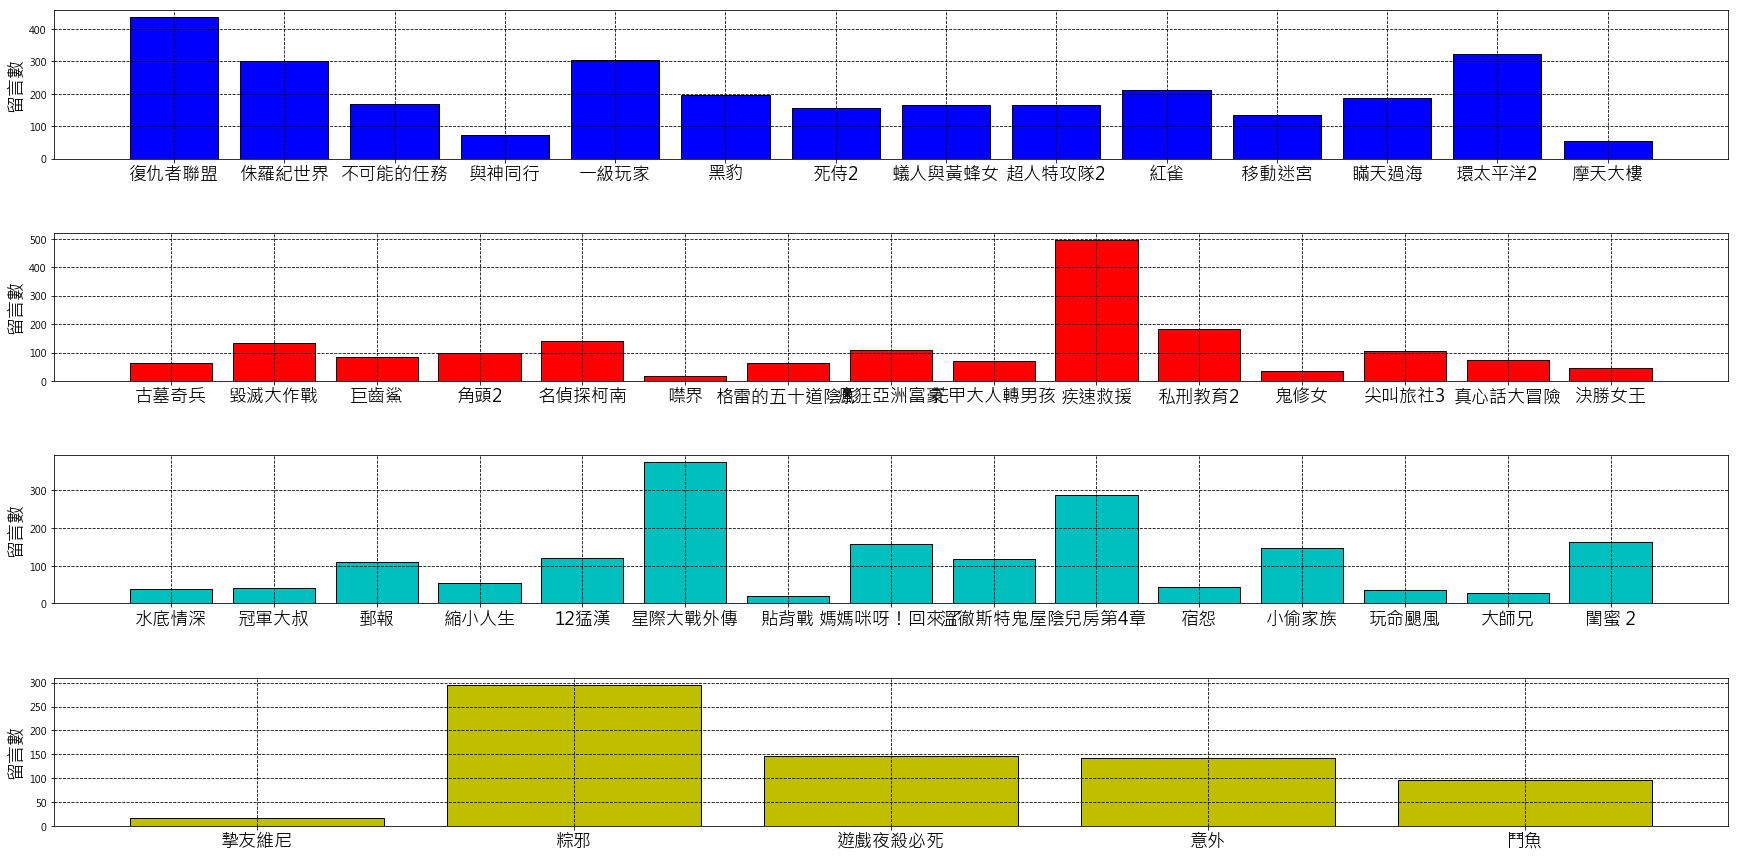

In [11]:
def vis_comment_num(all_comment_df, n, x_text_label_size = 8):

    movies_comment_num = all_comment_df.groupby(by = 'movies_key').size().reindex(index = main_table['names'])

    text_font = {'style': 'italic', 'color': 'black', 'weight': 'normal', 'size': x_text_label_size}
    
    #color_name = [name for name in mcd.CSS4_COLORS.keys()]
    color_name = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
    
    cut_seq = seq_point(movies_comment_num, n = n)
    cut_seq = list(map(lambda x: x -1 , cut_seq))

    fig, axs = plt.subplots(len(cut_seq), 1, figsize = (30, 15), facecolor = 'w', edgecolor = 'k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    for ind, num in enumerate(cut_seq):
        if ind == 0:
            temp_dat = movies_comment_num[ind:num]
        else:
            temp_dat = movies_comment_num[cut_seq[ind-1]:cut_seq[ind]]
        #axs[ind].plot(np.arange(len(temp_dat)), temp_dat, 'o-', linewidth = 3)
        axs[ind].bar(x = np.arange(len(temp_dat)), height = temp_dat, 
                     color = np.random.choice(color_name, size = 1, replace = False), edgecolor = 'k')
        
        #childrenLS = axs[ind].get_children()
        #barlist = list(filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), childrenLS))
        #for bar_item in barlist:
            #bar_item.set_color('b')
            
        axs[ind].grid(color = 'k', linestyle = '--')
        axs[ind].set_xticklabels(labels = temp_dat.index, fontdict = text_font) # replace x tick labels 
        axs[ind].set_xticks(np.arange(len(temp_dat)))
        axs[ind].set_ylabel(u'留言數', text_font)
        
vis_comment_num(all_comment_df, n = 15, x_text_label_size = 18)

### Clean Comment String

In [12]:
list_comment = all_comment_df['comment'].tolist()

def clean_string(list_comment):

    extract_pattern = re.compile(pattern = r'([\u4e00-\u9fff]+|[A-Za-z]+|\d+)') # extract traditional Chinese, English and digits
    url_pattern = re.compile(pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]|/|\.))+',
                             flags = re.IGNORECASE) # compile url pattern

    clean_comment = url_pattern.sub(repl = '', string = list_comment) # delete url 
    clean_comment = extract_pattern.findall(string = clean_comment) # extract traditional Chinese, English, digits
    clean_comment = ' '.join(clean_comment)
    
    return clean_comment

all_comment_df['comment'] = pd.Series(data = list(map(clean_string, list_comment)))
all_comment_df.head(3)

,user_name,publish_time,comment,movies_key
0,西瓜,2018-08-29 21:45:59,看完之後好難過 也感到在浪費時間因為結局讓人好難過,復仇者聯盟
1,Innocent Eyes,2018-08-26 21:44:34,Marvel 近期較差的片 大混戰處理得沒味道,復仇者聯盟
2,宏,2018-08-18 02:49:33,5 顆星給在特效做得很棒 雖然有些地方還蠻瞎的,復仇者聯盟


In [13]:
# translate English to Chinese
eng_pat = re.compile(pattern = '[A-Za-z]+', flags = re.IGNORECASE)
count = 0
ind_list = list() # get index
for comment in all_comment_df['comment'].values:
    if eng_pat.search(string = comment) != None:
        ind_list.append(count)
    count += 1
# translate to chinese
translator = Translator()
translations = translator.translate(all_comment_df['comment'][ind_list].tolist(), dest = 'zh-TW')
trans_list = [comment.text for comment in translations]
all_comment_df['comment'][ind_list] = pd.Series(data = trans_list, index = ind_list)

### The total number of  Reviews for each month

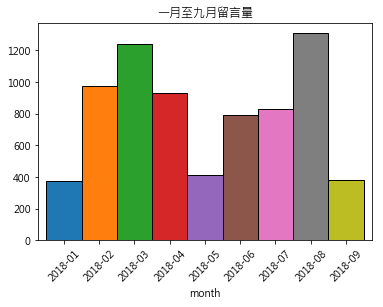

In [14]:
#Use publish_time to Index
all_comment_df['publish_time'] = pd.to_datetime(all_comment_df['publish_time'])
all_comment_df = all_comment_df.reset_index()
all_comment_df = all_comment_df.set_index(keys = 'publish_time')


comment_num = all_comment_df.resample(rule = 'M').size()
date_string = comment_num.index.astype(str).tolist()
month_string = [d[:7] for d in date_string]

comment_stat = {'month': month_string, 'total_comment': comment_num.values.tolist()}
comment_stat_df = pd.DataFrame(data = comment_stat)

comment_stat_df.plot.bar(x = 'month', y = 'total_comment', legend = False, title = '一月至九月留言量', 
                         rot = 45, width = 1, edgecolor = 'k')


### The number of Movie releasing of each month

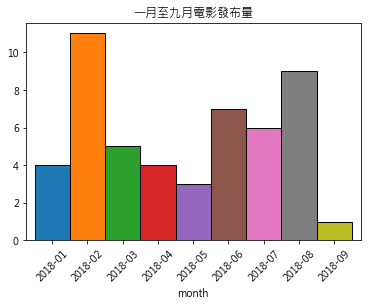

In [15]:
# Use date to index
main_table['date'] = pd.to_datetime(main_table['date'])
main_table = main_table.set_index(keys = 'date')

month_list = range(1, 10)

month_movies = {}
for mon in month_list:
    temp_names = main_table[main_table.index.month == mon]['names'].tolist()
    month_movies[mon] = temp_names

month_release_movie = [len(month_movies[key]) for key in month_movies]

date_range = pd.date_range(start = '2018-01', end = '2018-10', freq = 'M').astype(str).tolist()
date_string = [dat[:7] for dat in date_range]

month_release_info = {'month': date_string, 'release':month_release_movie}
month_release_df = pd.DataFrame(data = month_release_info)

month_release_df.plot.bar(x = 'month', y = 'release', legend = False, rot = 45, 
                          title = '一月至九月電影發布量', width = 1, edgecolor = 'k')

### Word Segmentation 

In [16]:
import jieba
import jieba.analyse
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
jieba.set_dictionary(dictionary_path = 'dictionary/Traditional Chinese dictionary.txt') # setting jieba dictionary 

In [18]:
# setting stop words
with open('stop_words\stops.txt', 'r', encoding = 'utf-8') as readfile:
        stops_words = readfile.read().split('\n')

In [19]:
# word segmentation and delete stop words
seg_dict = dict()
digit_pat = re.compile(pattern = r'\d+')
for ind, comment in zip(all_comment_df['index'], all_comment_df['comment'].values):
    term_list = [terms for terms in jieba.cut(sentence = comment, cut_all = False) if terms not in stops_words and len(terms) > 1 and digit_pat.match(terms) == None]
    seg_dict[ind] = term_list

Building prefix dict from G:\python_script\python_jupyter\python_script\NLP\dictionary\Traditional Chinese dictionary.txt ...
Loading model from cache C:\Users\Bing\AppData\Local\Temp\jieba.u477b27e0dd2ff18c5019414cb7126e31.cache
Loading model cost 0.620 seconds.
Prefix dict has been built succesfully.


In [20]:
seg_list = []
for ele in seg_dict.values():
    temp_list = [term for term in ele]
    seg_result = ' '.join(temp_list)
    seg_list.append(seg_result)

In [21]:
# term-document matrix
vectorizer = CountVectorizer(min_df = 1, encoding = 'utf-8')
tdm = vectorizer.fit_transform(raw_documents = seg_list)
words = vectorizer.get_feature_names()
tdm.toarray().shape

(7247, 14778)

In [22]:
# TF-Idf matrix
tfidf_vectorizer = TfidfVectorizer(encoding = 'utf-8')
tfidf_matrix = tfidf_vectorizer.fit_transform(raw_documents = seg_list)
tfidf_words = tfidf_vectorizer.get_feature_names()
tfidf_matrix.toarray().shape

(7247, 14778)

### Word Cloud by Terms Frequency

In [23]:
# get all terms from seg_dict
all_seg_term = list()
for key in seg_dict:
    all_seg_term.extend(seg_dict[key])

# count the term frequency
count_term_dict = {}
for term in all_seg_term:
    if term not in count_term_dict:
        count_term_dict[term] = 1
    else:
        count_term_dict[term] += 1

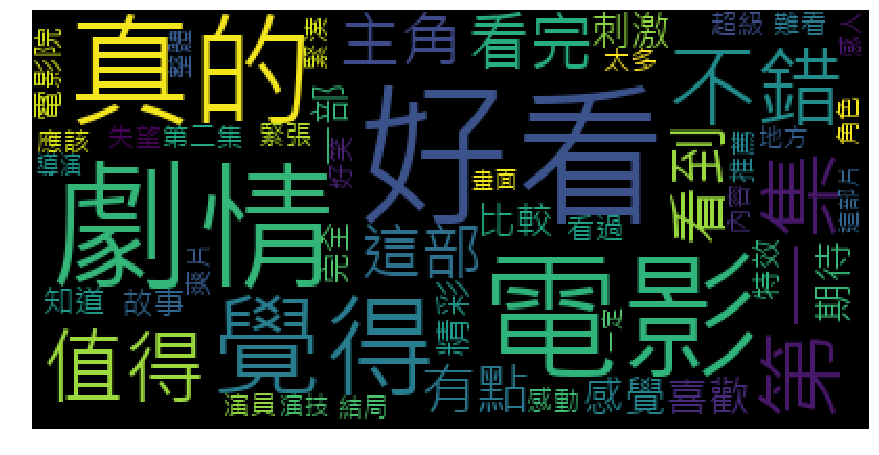

In [24]:
def plot_WordCloud(count_dict, max_words = 30):

    wc = WordCloud(font_path = "font/msj.ttf", max_words = max_words).generate_from_frequencies(count_dict)

    text_font = {'style': 'italic', 'color': 'black', 'weight': 'normal', 'size': 20}
    plt.figure(figsize = (15, 15))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
plot_WordCloud(count_dict = count_term_dict, max_words = 50)

### Word Cloud by high TF-IDF weight terms

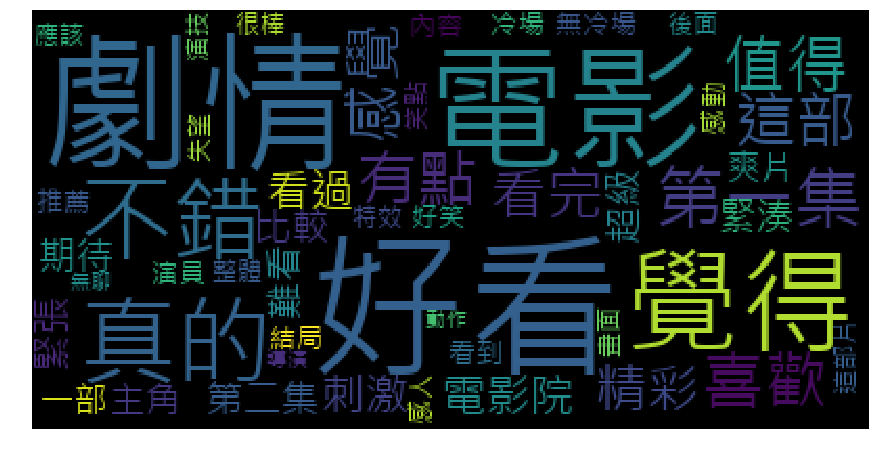

In [25]:
# extract key word by Tf-Idf
tfidf_key_word = list()
digit_pat = re.compile(pattern = r'\d+')
for comment in all_comment_df['comment'].values:
    terms_list = [terms for terms in jieba.analyse.extract_tags(sentence = comment, topK = 10, withWeight = False) if terms not in stops_words and digit_pat.match(terms) == None]
    tfidf_key_word.append(terms_list)
    
tfidf_keyword_count_dict = {}
for ls in tfidf_key_word:
    for term in ls:
        if term not in tfidf_keyword_count_dict:
            tfidf_keyword_count_dict[term] = 1
        else:
            tfidf_keyword_count_dict[term] += 1
            
plot_WordCloud(count_dict = tfidf_keyword_count_dict, max_words = 50)

### Top N Term's Frequency

In [26]:
term_stat = {'term': [], 'count_num': []}
for term, count_num in count_term_dict.items():
    term_stat['term'].append(term)
    term_stat['count_num'].append(count_num)

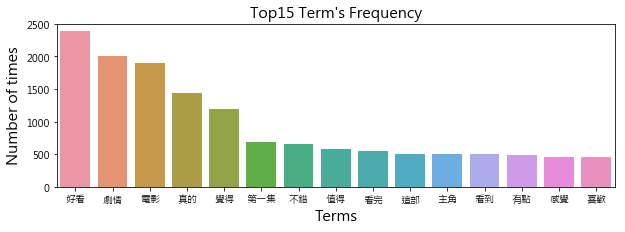

In [27]:
def top_terms(term_stat, n):

    label_font = {'color': 'black', 'size': 15, 'style': 'italic', 'weight': 'normal'}

    term_count_df = pd.DataFrame(data = term_stat, columns = ['term', 'count_num'])
    sort_terms = term_count_df.sort_values(by = 'count_num', ascending = False)[:n]

    plt.figure(figsize = (n - 5, 3))
    sns.barplot(x = 'term', y = 'count_num', data = sort_terms)
    plt.title("Top{:} Term's Frequency".format(n), fontdict = label_font)
    plt.ylabel('Number of times', fontdict = label_font)
    plt.xlabel('Terms', fontdict = label_font)
    plt.show()
    
top_terms(term_stat, n = 15)

### Top N Term's Frequency by TF-IDF Wight

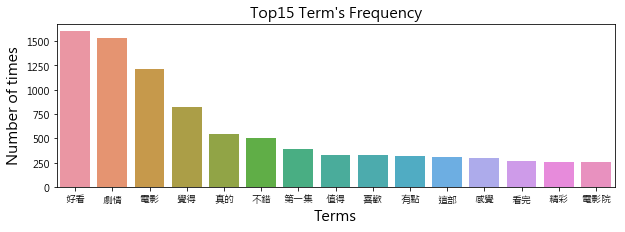

In [28]:
tfidf_term_stat = {'term': [], 'count_num': []}
for term, count_num in tfidf_keyword_count_dict.items():
    tfidf_term_stat['term'].append(term)
    tfidf_term_stat['count_num'].append(count_num)
    
top_terms(term_stat = tfidf_term_stat, n = 15)

### Write Word Segmentation to txt file

In [29]:
output_file_path = 'Movies data/seg_terms.txt'
with open(file = output_file_path, mode = 'w+', encoding = 'utf-8') as writefile:
    for sentence in seg_dict.values():
        for term in sentence:
            if term == sentence[-1]:
                writefile.write(term + '\n')
            else:
                writefile.write(term + ' ')

### Training Word2Vec

In [30]:
from gensim.models import word2vec

G:\Program_files2\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [38]:
sentences = word2vec.LineSentence(source = 'Movies data/seg_terms.txt')
# using cbow to training model
model = word2vec.Word2Vec(sentences = sentences, size = 50, window = 2, sg = 0, alpha = 0.01, min_count = 3) 

# save model
model.save('Movies data/word2vec.model')

# load model
#word2vec.Word2Vec.load('Movies data/word2vec.model')

In [40]:
model.wv.most_similar(u'鋼鐵人', topn = 10)

G:\Program_files2\Anaconda\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('許多', 0.9704141616821289),
 ('期待', 0.9682327508926392),
 ('角色', 0.9675118923187256),
 ('一部', 0.9674009084701538),
 ('好看', 0.9672400951385498),
 ('續集', 0.967064380645752),
 ('喜歡', 0.9669659733772278),
 ('世界', 0.966889500617981),
 ('漫威', 0.966840922832489),
 ('畫面', 0.9665917158126831)]

In [41]:
# get all word vector
def get_wordvec(model, vec_size):
    count = 0
    word_index = list()
    for term in model.wv.vocab.keys():
        count += 1
        if count == 1: 
            word_index.append(term)
            full_wordvec = model.wv.get_vector(word =term).reshape(-1, vec_size)
        else:
            word_index.append(term)
            temp_vec = model.wv.get_vector(word = term).reshape(-1, vec_size)
            full_wordvec = np.concatenate((full_wordvec, temp_vec), axis = 0)
            
    return word_index, full_wordvec   

In [42]:
word_index, word_vector = get_wordvec(model = model, vec_size = 50)

### Word Vector to csv file

In [43]:
wordvec_df = pd.DataFrame(data = word_vector, index = word_index)
wordvec_df.head(3)
#wordvec_df.to_csv('Movies data/word_vector.csv', encoding = 'utf-8')

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
看完,0.012590,-0.101038,0.003903,-0.193080,0.017607,-0.008296,-0.053436,0.107786,0.163527,-0.034639,...,-0.148287,0.293945,0.242714,0.128811,-0.118743,-0.038659,0.104965,0.331084,0.191799,-0.013933
之後,0.011133,-0.048042,0.007785,-0.078039,0.013358,0.002239,-0.011353,0.042398,0.065334,-0.004590,...,-0.048941,0.118660,0.085893,0.051106,-0.054946,-0.015018,0.036265,0.117132,0.075293,-0.002574
難過,-0.006264,-0.004190,0.004117,-0.005938,0.007620,0.007709,-0.008190,0.016319,0.016020,-0.001167,...,-0.017970,0.017981,0.023125,0.017654,-0.014206,-0.010143,0.007607,0.022850,0.020560,-0.004372


### Principal Component Analysis(PCA)
  - Using PCA to reduce dimensionality.

In [44]:
from sklearn.decomposition import PCA

In [45]:
pca = PCA(n_components = 2)
reduce_vector = pca.fit_transform(X = word_vector)

In [46]:
def get_similarity_term_vector(model, word_index, word, word_vector, n, adding_word = True):
    sim_terms = [term for term, value in model.wv.most_similar(word, topn = n)]
    if adding_word:
        sim_terms.insert(0, word) # adding word 
    sim_terms_index = [word_index.index(term) for term in sim_terms]
    
    return sim_terms, reduce_vector[sim_terms_index, :]

### Visualize Word Vector

G:\Program_files2\Anaconda\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


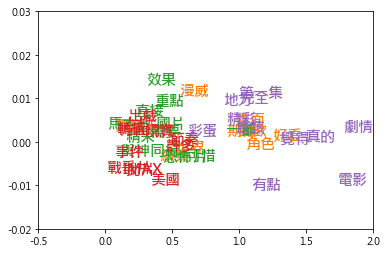

In [47]:
sim_term1, vector1 = get_similarity_term_vector(model = model, word_index = word_index, word = u'鋼鐵人',
                                                 word_vector = reduce_vector, n = 10, adding_word = True)

sim_term2, vector2 = get_similarity_term_vector(model = model, word_index = word_index, word = u'馬大叔', 
                                                 word_vector = reduce_vector, n = 10, adding_word = True)

sim_term3, vector3 = get_similarity_term_vector(model = model, word_index = word_index, word = u'戰爭片',
                                                 word_vector = reduce_vector, n = 10, adding_word = True)

sim_term4, vector4 = get_similarity_term_vector(model = model, word_index = word_index, word = u'彩蛋',
                                                 word_vector = reduce_vector, n = 10, adding_word = True)
    
text_font = {'color': 'black', 'size': 15, 'style': 'italic', 'weight': 'bold'}
    
fig = plt.figure()
ax = fig.add_subplot(111)

for term, vec in zip(sim_term1, vector1):
    ax.text(x = vec[0], y = vec[1], s = term, color= 'C1', fontdict = text_font)
    
for term, vec in zip(sim_term2, vector2):
    ax.text(x = vec[0], y = vec[1], s = term, color= 'C2', fontdict = text_font)
    
for term, vec in zip(sim_term3, vector3):
    ax.text(x = vec[0], y = vec[1], s = term, color= 'C3', fontdict = text_font)
    
for term, vec in zip(sim_term4, vector4):
    ax.text(x = vec[0], y = vec[1], s = term, color= 'C4', fontdict = text_font)
    
    
ax.axis([-0.5, 2, -0.02, 0.03])
plt.figure(figsize=(60,60))
plt.show()

### View the top10 similarity words

In [48]:
[sim_term1, sim_term2, sim_term3, sim_term4]

[['鋼鐵人', '許多', '期待', '角色', '一部', '好看', '續集', '喜歡', '世界', '漫威', '畫面'],
 ['馬大叔', '直接', '國片', '效果', '與神同行', '精采', '恐怖片', '可惜', '需要', '重點', '一部'],
 ['戰爭片', '方面', '現實', '此片', '轉折', '節奏', '事件', '美國', '許多', 'IMAX', '出戲'],
 ['彩蛋', '劇情', '第一集', '電影', '真的', '覺得', '精彩', '有點', '完全', '地方', '應該']]

### Reference:
   - [gensim offical websit](https://radimrehurek.com/gensim/models/word2vec.html)
   
   
   - [自然語言處理入門- Word2vec小實作](https://medium.com/pyladies-taiwan/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86%E5%85%A5%E9%96%80-word2vec%E5%B0%8F%E5%AF%A6%E4%BD%9C-f8832d9677c8)
   
   
   - [解決Python 3 Matplotlib與Seaborn視覺化套件中文顯示問題](https://medium.com/@aitmr1234567890/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b)
   
   
   - [以 gensim 訓練中文詞向量](http://zake7749.github.io/2016/08/28/word2vec-with-gensim/)
   
   
   - [Distributed Representations of Words and Phrases
and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf)